In [3]:
import  keras
import  numpy  as  np
import  tensorflow  as  tf
import  matplotlib.pyplot  as  plt
from  keras  import  backend  as  k
from tensorflow.keras.preprocessing import image
from  keras.applications.inception_v3  import  InceptionV3, decode_predictions

tf.compat.v1.disable_eager_execution ()

In [4]:
iv3 = InceptionV3()

Instructions for updating:
Colocations handled automatically by placer.
96112376/96112376 [==============================] - 6s 0us/step


2023-07-07 14:26:11.599322: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.
2023-07-07 14:26:11.717976: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:353] MLIR V1 optimization pass is not enabled
2023-07-07 14:26:12.121620: W tensorflow/c/c_api.cc:300] Operation '{name:'conv2d_59/kernel/Assign' id:3519 op device:{requested: '', assigned: ''} def:{{{node conv2d_59/kernel/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](conv2d_59/kernel, conv2d_59/kernel/Initializer/stateless_random_uniform)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


In [ ]:
# iv3.summary()

In [22]:
kitty = './kitty_2.png'
stop = 'Stop.png'
hackImage = 'hackImage.png'
img = image.img_to_array(image.load_img(stop, target_size=(299, 299)))
print(img)

[[[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 ...

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]]


/home/santi/anaconda3/envs/asturcon/lib/python3.10/site-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Si se imprime img los resultados van a ser de 0 a 255 los colores pero incepcion funciona de -1 a 1 para lo cual se va a reescalar la imagen

In [23]:
# Conversión de 0-255 a 0-1
img /= 255
img -= 0.5
img *= 2

In [24]:
# El modelo pide que entre un tensor con una dimension mas esa dimension extra es el tamaño del batch (+1 imágen)
img = img.reshape([1, img.shape[0], img.shape[1], img.shape[2]])
print (img.shape)

(1, 299, 299, 3)


In [25]:
# Predicción
y=iv3.predict(img)
decode_predictions(y)

[[('n06794110', 'street_sign', 0.79925406),
  ('n07248320', 'book_jacket', 0.029274134),
  ('n04443257', 'tobacco_shop', 0.01084433),
  ('n04019541', 'puck', 0.008632655),
  ('n03916031', 'perfume', 0.006675101)]]


## Ataque adversario

In [26]:
# Vamos a construir un nuevo grapho que permita clasificar las imágenes.
inp_layer = iv3.layers[0].input
out_layer = iv3.layers[-1].output
target_class = 951 # Limón
loss = out_layer[0, target_class]
grad = k.gradients(loss, inp_layer)[0]

# Que calcule el grafo de gradientes entre el tensor y la funcion de coste #tensor que dice como variar los pixeles
optimize_gradient = k.function([inp_layer, k.learning_phase()], [grad, loss])


In [27]:

pert=1
max_pert=img+pert
min_pert=img-pert
adv = np.copy(img)
cost = 0.0
while cost<0.95:
    gr, cost = optimize_gradient([adv,0]) #0 es que estamos en modo testing
    adv += gr #sumarle los pixeles para que se vea manipulado
    adv=np.clip(adv,min_pert,max_pert)#hace que la imagen se encuentre en el rango de perturbacion
    print("target cost: ", cost) #que imprima el coste

target cost:  9.441893e-05
target cost:  9.4581614e-05
target cost:  9.4984396e-05
target cost:  9.5887095e-05
target cost:  9.682034e-05
target cost:  9.782784e-05
target cost:  9.885152e-05
target cost:  9.98919e-05
target cost:  0.00010097899
target cost:  0.00010211785
target cost:  0.00010329337
target cost:  0.00010444322
target cost:  0.00010562952
target cost:  0.0001068396
target cost:  0.000108091815
target cost:  0.000109350185
target cost:  0.00011062224
target cost:  0.00011193379
target cost:  0.000113246584
target cost:  0.00011457953
target cost:  0.00011594021
target cost:  0.000117338284
target cost:  0.00011872676
target cost:  0.00012016091
target cost:  0.000121667166
target cost:  0.00012321032
target cost:  0.00012478846
target cost:  0.00012643765
target cost:  0.00012809418
target cost:  0.0001297378
target cost:  0.0001313962
target cost:  0.00013307313
target cost:  0.00013475683
target cost:  0.00013646795
target cost:  0.00013819279
target cost:  0.00013995

In [28]:
print(adv.shape)

(1, 299, 299, 3)


In [29]:
adv /= 2
adv += 0.5
adv *= 255

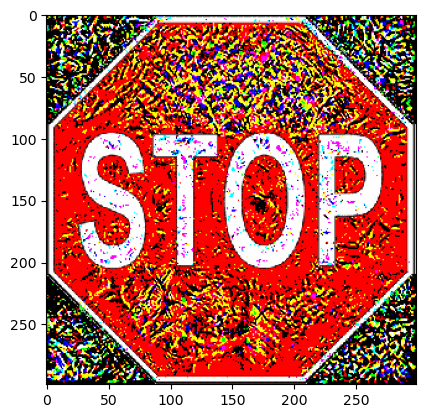

In [30]:
plt.imshow(adv[0].astype(np.uint8))
plt.show()

In [31]:
y=iv3.predict(adv)
decode_predictions(y)#pasa de y al resultado

[[('n03950228', 'pitcher', 1.0),
  ('n03598930', 'jigsaw_puzzle', 8.245931e-12),
  ('n04131690', 'saltshaker', 3.081478e-13),
  ('n03617480', 'kimono', 1.779301e-17),
  ('n01910747', 'jellyfish', 1.9013184e-23)]]

In [32]:
from PIL import Image
im=Image.fromarray(adv[0].astype(np.uint8))
im.save(data_dir +"hackImage.png")